<a href="https://colab.research.google.com/github/JurugoBrian/Chest_Opacity/blob/main/chest_opacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<strong>Name:</strong> Anyanzo Ivan Brian <br>
<strong>Student No:</strong> 2000717674 <br>
<strong>Registration No:</strong> 2020/HD05/17674U <br>
<strong>Course:</strong> Master of Science in Computer Science

Introduction: This project uses opencv, tensorflow, and sklearn libraries to develop and train a deep neural network. A VGG-16 convolutional neural network (16 layers deep) is trained using transfer learning.

<strong>Step 1:</strong> Import the required libraries

In [1]:
import os
import warnings
import random
import cv2
from shutil import copyfile
import glob
from google.colab import drive
import pathlib
from imutils import paths

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Lambda, AveragePooling2D, Dropout, Flatten, Dense, Input

<strong>Step 2:</strong> Load all the datasets provided

In [2]:
drive.mount('/content/drive', force_remount = True)


# Create a new directory for working with the data
chest_opacity_dir = '/content/chest_opacity/'
if not os.path.exists(chest_opacity_dir):
	os.makedirs(chest_opacity_dir)

# Create the dataset1 and dataset2 folders in the chest_opacity folder
dataset1_dir = os.path.join(chest_opacity_dir, 'dataset1')
if not os.path.exists(dataset1_dir):
  os.mkdir(dataset1_dir)
dataset2_dir = os.path.join(chest_opacity_dir, 'dataset2')
if not os.path.exists(dataset2_dir):
  os.mkdir(dataset2_dir)

# Create the known_images and unknown_images folders in dataset1 folder
known_images_dir = os.path.join(dataset1_dir, 'known_images')
if not os.path.exists(known_images_dir):
  os.mkdir(known_images_dir)
unknown_images_dir = os.path.join(dataset1_dir, 'unknown_images')
if not os.path.exists(unknown_images_dir):
  os.mkdir(unknown_images_dir)

# Create the normal and sick folders in known_images folder
normal_dir = os.path.join(known_images_dir, 'normal')
if not os.path.exists(normal_dir):
  os.mkdir(normal_dir)
sick_dir = os.path.join(known_images_dir, 'sick')
if not os.path.exists(sick_dir):
  os.mkdir(sick_dir)

# Create the training and testing folders in normal folder
training_dir = os.path.join(normal_dir, 'training')
if not os.path.exists(training_dir):
  os.mkdir(training_dir)
testing_dir = os.path.join(normal_dir, 'testing')
if not os.path.exists(testing_dir):
  os.mkdir(testing_dir)

# Create the training and testing folders in sick folder
training_dir = os.path.join(sick_dir, 'training')
if not os.path.exists(training_dir):
  os.mkdir(training_dir)
testing_dir = os.path.join(sick_dir, 'testing')
if not os.path.exists(testing_dir):
  os.mkdir(testing_dir)

Mounted at /content/drive


In [3]:
# Specifying the data sources for training and testing for normal images
KNOWN_SOURCE_DIR = '/content/drive/MyDrive/Deep_Learning_Assignment/dataset1/known_images/'

NORMAL_SOURCE_DIR =   '/content/drive/MyDrive/Deep_Learning_Assignment/dataset1/known_images/normal/'
TRAINING_NORMAL_DIR = '/content/chest_opacity/dataset1/known_images/normal/training/'
TESTING_NORMAL_DIR = '/content/chest_opacity/dataset1/known_images/normal/testing/'

SICK_SOURCE_DIR =   '/content/drive/MyDrive/Deep_Learning_Assignment/dataset1/known_images/sick/'
TRAINING_SICK_DIR = '/content/chest_opacity/dataset1/known_images/sick/training/'
TESTING_SICK_DIR = '/content/chest_opacity/dataset1/known_images/sick/testing/'

# Specifying the data sources for unknown images
UNKNOWN_SOURCE_DIR = '/content/drive/MyDrive/Deep_Learning_Assignment/dataset1/unknown_images/'

# Specifying the dataset2 sources
DATASET2_SOURCE_DIR = '/content/drive/MyDrive/Deep_Learning_Assignment/dataset2/'

<strong>Step 3:</strong> Exploratory analysis of images in the known dataset

<function matplotlib.pyplot.show(*args, **kw)>

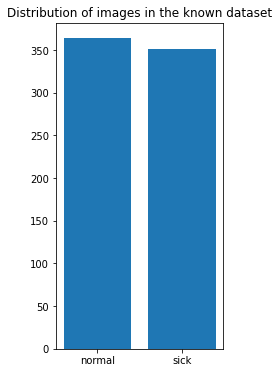

In [4]:
# Loop through images in the known dataset and plot the results
image_folder = ['normal', 'sick']
nimgs = {}
for i in image_folder:
    nimages = len(os.listdir(KNOWN_SOURCE_DIR+i+'/'))
    nimgs[i] = nimages
plt.figure(figsize=(3, 6))
plt.bar(range(len(nimgs)), list(nimgs.values()), align='center')
plt.xticks(range(len(nimgs)), list(nimgs.keys()))
plt.title('Distribution of images in the known dataset')
plt.show

In [5]:
# Print number of images in the known dataset
for i in image_folder:
    print('{} images are:'.format(i)+str(len(os.listdir(KNOWN_SOURCE_DIR+i+'/'))))

normal images are:364
sick images are:351


Exploratory analysis shows that the number normal and sick images are almost equal. Therefore the known dataset is relatively balanced

In [6]:
# Loop through all normal images in the known datasets
normal_hash = list()
for file_path in glob.glob(NORMAL_SOURCE_DIR+"*.png"):
    file_name = os.path.basename(file_path)
    category = file_name.split("_")[0]
    normal_hash.append({"Category":category,"Image Name":file_name})

In [7]:
ndf = pd.DataFrame(normal_hash)
# First 5 images in the normal images in known dataset
ndf.head(5)

,Category,Image Name
0,normal,normal_101.png
1,normal,normal_0.png
2,normal,normal_103.png
3,normal,normal_108.png
4,normal,normal_102.png


In [8]:
# Last 5 images in the normal images in known dataset
ndf.tail(5)

,Category,Image Name
359,normal,normal_92.png
360,normal,normal_84.png
361,normal,normal_90.png
362,normal,normal_88.png
363,normal,normal_83.png


In [9]:
# Loop through all sick images in the known datasets
sick_hash = list()
for file_path in glob.glob(SICK_SOURCE_DIR+"*.png"):
    file_name = os.path.basename(file_path)
    category = file_name.split("_")[0]
    sick_hash.append({"Category":category,"Image Name":file_name})

In [10]:
sdf = pd.DataFrame(sick_hash)
# First 5 sick images in the known dataset
sdf.head(5)

,Category,Image Name
0,sick,sick_1.png
1,sick,sick_0.png
2,sick,sick_101.png
3,sick,sick_104.png
4,sick,sick_10.png


In [11]:
# Last 5 images in the normal images in known dataset
ndf.tail(5)

,Category,Image Name
359,normal,normal_92.png
360,normal,normal_84.png
361,normal,normal_90.png
362,normal,normal_88.png
363,normal,normal_83.png


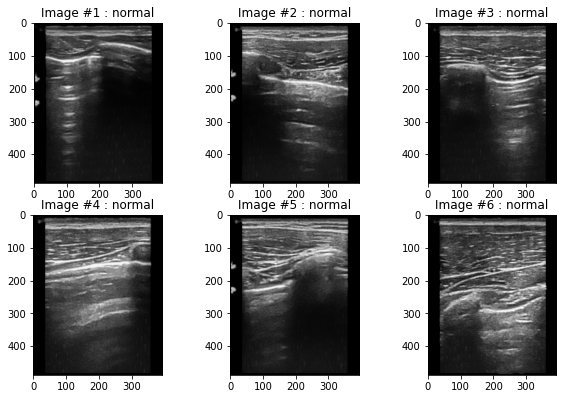

In [12]:
# Visualize the first 6 normal images
normal_class_list = list()
normal_images_list = list()
for k in ndf.sample(6).itertuples():
    normal_class_list.append(k[1])
    img = cv2.imread(NORMAL_SOURCE_DIR+k[2])
    normal_images_list.append(img)

plt.figure(figsize=(10,10))
columns = 3
for i in range(6):
    plt.subplot(int(len(normal_images_list)/ columns + 1), columns, i + 1)
    plt.imshow(normal_images_list[i])
    plt.title('Image #{} : '.format(i+1) + normal_class_list[i])

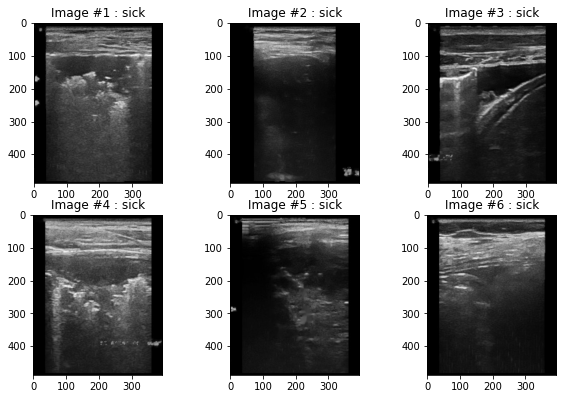

In [13]:
# Visualize the first 6 sick images
sick_class_list = list()
sick_images_list = list()
for k in sdf.sample(6).itertuples():
    sick_class_list.append(k[1])
    img = cv2.imread(SICK_SOURCE_DIR+k[2])
    sick_images_list.append(img)

plt.figure(figsize=(10,10))
columns = 3
for i in range(6):
    plt.subplot(int(len(sick_images_list)/ columns + 1), columns, i + 1)
    plt.imshow(sick_images_list[i])
    plt.title('Image #{} : '.format(i+1) + sick_class_list[i])

<strong>Step 4:</strong> Data preprocessing

In [14]:
# Function to split known data into training and testing

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    test_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)
    
    for filename in test_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [15]:
# Split the known datasets (normal and sick images) into training and testing
split_size = 0.90
split_data(NORMAL_SOURCE_DIR, TRAINING_NORMAL_DIR, TESTING_NORMAL_DIR, split_size)
split_data(SICK_SOURCE_DIR, TRAINING_SICK_DIR, TESTING_SICK_DIR, split_size)

In [16]:
# Method to get features and labels from the training dataset

def feature_lables(path, label):
  
  print("[INFO] loading images...")
  data = []
  labels = []
  image_label = label
  images_path = list(paths.list_images(path))
  
  # loop over the image paths
  for all_images in images_path:
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(all_images)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(image_label)

  return data, labels

In [17]:
# Get features and labels for the  normal and sick training dataset
nlabel = "normal"
slabel = "sick"
lb = LabelBinarizer()

train_x, train_y = feature_lables(TRAINING_NORMAL_DIR, nlabel)
train_sick_features, train_sick_labels = feature_lables(TRAINING_SICK_DIR, slabel)
train_x.extend(train_sick_features)
train_y.extend(train_sick_labels)

# perform one-hot encoding on the train_y labels
train_y = lb.fit_transform(train_y)
train_y = to_categorical(train_y)

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
train_x = np.array(train_x) / 255.0
train_y = np.array(train_y)


# Get features and labels for the  normal and sick test dataset
test_x, test_y = feature_lables(TESTING_NORMAL_DIR, nlabel)
test_sick_features, test_sick_labels = feature_lables(TESTING_SICK_DIR, slabel)
test_x.extend(test_sick_features)
test_y.extend(test_sick_labels)

# perform one-hot encoding on the test_y labels
test_y = lb.fit_transform(test_y)
test_y = to_categorical(test_y)

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
test_x = np.array(test_x) / 255.0
test_y = np.array(test_y)


[INFO] loading images...
[INFO] loading images...
[INFO] loading images...
[INFO] loading images...


<strong>Step 5:</strong> Building the model

In [18]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

# Initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-3
EPOCHS = 100
BS = 14

# load the VGG16 network, ensuring the head FC layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.6)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<strong>Step 6:</strong> Training the model

In [20]:
# compile the model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
  trainAug.flow(train_x, train_y, batch_size=BS),
    steps_per_epoch=len(train_x) // BS,
    validation_data=(test_x, test_y),
    validation_steps=len(test_y) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/100
50/50 [==============================] - 15s 205ms/step - loss: 0.6350 - accuracy: 0.6647 - val_loss: 0.5165 - val_accuracy: 0.8571
Epoch 2/100
50/50 [==============================] - 9s 180ms/step - loss: 0.4657 - accuracy: 0.7784 - val_loss: 0.4402 - val_accuracy: 0.8500
Epoch 3/100
50/50 [==============================] - 8s 167ms/step - loss: 0.3800 - accuracy: 0.8388 - val_loss: 0.3827 - val_accuracy: 0.8857
Epoch 4/100
50/50 [==============================] - 9s 179ms/step - loss: 0.3210 - accuracy: 0.8791 - val_loss: 0.3391 - val_accuracy: 0.9071
Epoch 5/100
50/50 [==============================] - 9s 179ms/step - loss: 0.3079 - accuracy: 0.8806 - val_loss: 0.3454 - val_accuracy: 0.8571
Epoch 6/100
50/50 [==============================] - 9s 180ms/step - loss: 0.2857 - accuracy: 0.8906 - val_loss: 0.3308 - val_accuracy: 0.8643
Epoch 7/100
50/50 [==============================] - 8s 169ms/step - loss: 0.2763 - accurac

In [21]:
print("Loss of the model is - " , model.evaluate(test_x,test_y)[0])
print("Accuracy of the model is - " , model.evaluate(test_x, test_y)[1]*100 , "%")

5/5 [==============================] - 5s 454ms/step - loss: 0.0443 - accuracy: 0.9929
Loss of the model is -  0.044346392154693604
5/5 [==============================] - 1s 128ms/step - loss: 0.0443 - accuracy: 0.9929
Accuracy of the model is -  99.28571581840515 %


<strong>Step 7:</strong> Models performance metrics

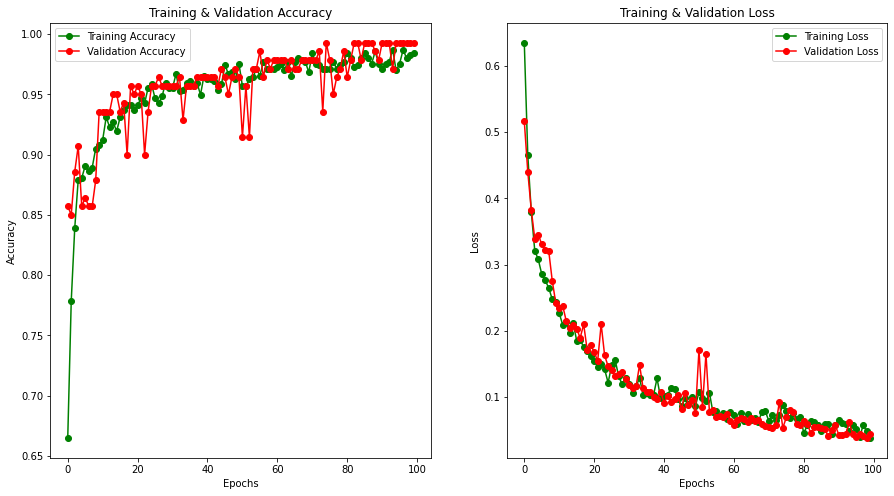

In [22]:
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = H.history['accuracy']
train_loss = H.history['loss']
val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']
fig.set_size_inches(15, 8)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [23]:
model.save("./vgg16")

<strong>Step 8:</strong> Preditions on unknown images

In [24]:
def new_images(path):
  # grab the list of images in our dataset directory, then initialize
  # the list of data (i.e., images) and class images
  print("[INFO] loading images...")
  imagePaths = list(paths.list_images(path))
  unknown_data = []
  
  # loop over the image paths
  for imagePath in imagePaths:
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # Gaussian blur for smothening and removing noise in the image
    #image = cv2.GaussianBlur(image,(5,5),0)
    # Combined X and Y Sobel Edge Detection
    #image = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
    
    # update the data and labels lists, respectively
    unknown_data.append(image)
    
  # convert the data and labels to NumPy arrays while scaling the pixel
  # intensities to the range [0, 1]
  unknown_data = np.array(unknown_data) / 255.0

  return unknown_data

In [25]:
# Predicting images in the un_known dataset
model = tf.keras.models.load_model("./vgg16")
unknown_images = new_images(UNKNOWN_SOURCE_DIR)
predict_unknown = model.predict(unknown_images)

# Generate arg maxes for predictions
# Generate arg maxes for predictions
classes = np.argmax(predict_unknown, axis = 1)
print(classes)

[INFO] loading images...
2/2 [==============================] - 2s 2s/step
[0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1
 1 1 0 0 1 0 1 0 1 0 0 0 1]


<strong>Step 8:</strong> Preditions on dataset 2

In [45]:
def dataset2_images(path):
  # grab the list of images in our dataset directory, then initialize
  # the list of data (i.e., images) and class images
  print("[INFO] loading images...")
  imagePaths = list(paths.list_images(path))
  unknown_data = []
  
  # loop over the image paths
  for imagePath in imagePaths:
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # Gaussian blur for smothening and removing noise in the image
    #image = cv2.GaussianBlur(image,(5,5),0)
    # Combined X and Y Sobel Edge Detection
    image = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
    
    # update the data and labels lists, respectively
    unknown_data.append(image)
    
  # convert the data and labels to NumPy arrays while scaling the pixel
  # intensities to the range [0, 1]
  unknown_data = np.array(unknown_data) / 255.0

  return unknown_data

In [46]:
# Load the data and make preditions
dataset2 = dataset2_images(DATASET2_SOURCE_DIR)
dataset2_predict = model.predict(dataset2)

# Generate arg maxes for predictions
dataset2_classes = np.argmax(dataset2_predict, axis = 1)
print(dataset2_classes)

[INFO] loading images...
7/7 [==============================] - 1s 152ms/step
[1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
